In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
#load data

In [4]:
daily_df = pd.read_csv("dataset/stations_daily.csv")

In [5]:
hourly_df = pd.read_csv("dataset/stations_hourly.csv")

In [6]:
rsinaica_df = pd.read_csv("dataset/stations_rsinaica.csv")

# จัดการกับข้อมูลรายงานฝุ่นรายวันก่อน

we will use this dataframe to calculate the yearly statistic of ฝุ่น

In [7]:
daily_df.head()

,datetime,station_id,PM2.5,PM10,NOx,O3,CO,HR,NO,NO2,...,HCT,HRI,IUV,PB,PP,PST,RS,TMPI,UVA,XIL
0,2015-04-02,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.361000,NaN,NaN
1,2015-05-21,32,0.454967,0.347400,0.059194,0.029176,NaN,44.879091,0.029525,0.053121,...,NaN,NaN,NaN,570.775455,0.296364,NaN,7.871636,16.792818,NaN,NaN
2,2015-05-22,32,0.077821,0.389323,0.019158,0.051903,NaN,42.506000,0.009589,0.014215,...,NaN,NaN,NaN,558.360000,0.002750,NaN,384.788079,17.018949,NaN,NaN
3,2015-05-23,32,0.018036,0.387729,0.019711,0.021092,0.144603,54.734437,0.009863,0.013436,...,NaN,NaN,NaN,573.282187,0.038750,NaN,252.605975,18.575000,NaN,NaN
4,2015-05-24,32,0.024935,0.398042,0.024757,0.009568,0.494143,58.374574,0.012397,0.010337,...,NaN,NaN,NaN,572.169574,0.003404,NaN,259.231664,16.781064,NaN,NaN


Let's add year and month columns to daily_df 

In [8]:
daily_df.insert(1, "year", daily_df["datetime"].apply(lambda x: x.split("-")[0]))
daily_df.insert(1, "month", daily_df["datetime"].apply(lambda x: x.split("-")[1]))

convert month and year to int \
then sort values by month and year

In [9]:
daily_df["month"] = pd.to_numeric(daily_df["month"])
daily_df["year"] = pd.to_numeric(daily_df["year"])

daily_df.sort_values(by=["year", "month"], inplace = True)
daily_df.head()

,datetime,month,year,station_id,PM2.5,PM10,NOx,O3,CO,HR,...,HCT,HRI,IUV,PB,PP,PST,RS,TMPI,UVA,XIL
59820,2000-01-01,1,2000,102,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59821,2000-01-02,1,2000,102,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59822,2000-01-03,1,2000,102,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59823,2000-01-04,1,2000,102,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59824,2000-01-05,1,2000,102,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


count the values exist each year

In [10]:
groupDaily_by_year = daily_df.groupby("year")
groupDaily_by_year.count()

,datetime,month,station_id,PM2.5,PM10,NOx,O3,CO,HR,NO,...,HCT,HRI,IUV,PB,PP,PST,RS,TMPI,UVA,XIL
year,,,,,,,,,,,,,,,,,,,,,
2000,1678,1678,1678,0,0,0,0,0,0,1678,...,0,0,0,0,0,0,0,0,0,0
2001,1658,1658,1658,0,0,0,0,0,0,1658,...,0,0,0,0,0,0,0,0,0,0
2002,826,826,826,0,0,0,0,0,0,826,...,0,0,0,0,0,0,0,0,0,0
2006,321,321,321,0,0,0,0,0,0,321,...,0,0,0,0,0,0,0,0,0,0
2007,44,44,44,0,0,0,0,0,0,44,...,0,0,0,0,0,0,0,0,0,0
2008,43,43,43,0,0,0,0,0,0,43,...,0,0,0,0,0,0,0,0,0,0
2009,43,43,43,0,0,0,0,0,0,43,...,0,0,0,0,0,0,0,0,0,0
2010,10417,10417,10417,3814,7612,151,8235,6816,151,1069,...,0,0,0,140,0,0,0,0,0,0
2011,11315,11315,11315,5374,8473,61,10057,6298,65,1836,...,0,29,0,36,27,0,0,25,0,0


In [11]:
# we will keep a year if PM2.5 have data > 30 %
def keep_year(group):
    return ((group.count()["PM2.5"] * 100) / group.count()["datetime"] > 50)
daily_df = groupDaily_by_year.filter(keep_year)

filter data

In [12]:
daily_df = groupDaily_by_year.filter(keep_year)
daily_df["year"].unique()

array([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021])

next we will drop column which have few data

In [13]:
daily_df.isna().sum()* 100 / len(daily_df)

#show % of Nan values in each column, we will drop at 51 %

datetime        0.000000
month           0.000000
year            0.000000
station_id      0.000000
PM2.5          23.970884
PM10           19.419134
NOx            41.364588
O3             15.611430
CO             20.965542
HR             35.960491
NO             43.242666
NO2            24.668069
TMP            34.016287
BEN            99.596476
CH4            99.859417
CN             99.690198
CO2            99.970842
H2S            99.854211
HCNM           99.854731
HCT           100.000000
HRI            94.701601
IUV            97.430464
PB             52.365431
PP             60.863385
PST           100.000000
RS             60.719678
TMPI           82.110092
UVA            91.752491
XIL            99.596476
dtype: float64

Too many Nan values OMG

In [14]:
for col in daily_df:
    if daily_df[col].isna().sum()* 100 / len(daily_df) > 51:
        daily_df.drop(col, axis=1,inplace=True)

daily_df.reset_index(drop = True)

,datetime,month,year,station_id,PM2.5,PM10,NOx,O3,CO,HR,NO,NO2,TMP
0,2013-01-01,1,2013,68,37.084448,79.583333,NaN,0.014000,0.418750,NaN,NaN,NaN,NaN
1,2013-01-02,1,2013,68,16.040586,61.333333,NaN,0.011917,0.383750,NaN,NaN,NaN,NaN
2,2013-01-03,1,2013,68,11.880552,57.739130,NaN,0.015958,0.364583,NaN,NaN,NaN,NaN
3,2013-01-04,1,2013,68,13.000137,55.375000,NaN,0.013208,0.420833,NaN,NaN,NaN,NaN
4,2013-01-05,1,2013,68,18.025929,72.625000,NaN,0.012542,0.431667,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
192053,2021-12-27,12,2021,426,28.956522,67.375000,0.036429,0.030750,1.684583,56.541667,NaN,0.024762,21.660833
192054,2021-12-28,12,2021,426,20.818182,55.833333,0.037508,0.026792,1.700000,44.375000,NaN,0.023225,23.731250
192055,2021-12-29,12,2021,426,16.857143,51.458333,0.045588,0.017083,1.732917,37.875000,NaN,0.026500,22.751250
192056,2021-12-30,12,2021,426,21.555556,51.750000,0.037229,0.029833,1.520000,42.916667,NaN,0.023929,22.988333


In [15]:
group_by_y = daily_df.set_index("year").groupby("year")
group_by_y["PM2.5"].mean()

year
2013    2.870717e+01
2014    2.646882e+01
2015    3.329578e+01
2016    5.457275e+01
2017    5.492572e+01
2018    4.002737e+01
2019    2.884864e+01
2020    1.788649e+34
2021    4.701081e+02
Name: PM2.5, dtype: float64

In [16]:
# something wrong with 2020
twenty_sort = daily_df[daily_df["year"]==2020].sort_values("PM2.5",ascending=False)
#we can agree that row 1, 2, 3 is an outlier
twenty_sort.head()

,datetime,month,year,station_id,PM2.5,PM10,NOx,O3,CO,HR,NO,NO2,TMP
9366,2020-07-13,7,2020,59,1.806160e+38,1.412893e+38,NaN,0.010338,0.981094,72771.476818,NaN,NaN,83890.660955
9365,2020-07-12,7,2020,59,1.000740e+38,4.905567e+37,NaN,NaN,0.261321,175143.866667,NaN,NaN,202409.533333
9364,2020-07-11,7,2020,59,7.927562e+37,4.558188e+37,NaN,NaN,0.964935,8925.452105,NaN,NaN,34847.181421
98697,2020-10-14,10,2020,134,1.000092e+03,2.144815e+01,NaN,0.022022,0.184360,58.912799,NaN,0.008879,22.014575
98726,2020-11-12,11,2020,134,1.000077e+03,4.880327e+01,NaN,0.038890,0.313007,45.981627,NaN,0.012959,23.412954


In [17]:
daily_df.drop([9366, 9365, 9364], inplace=True)

In [18]:
daily_df.corr()

,month,year,station_id,PM2.5,PM10,NOx,O3,CO,HR,NO,NO2,TMP
month,1.000000,-0.030524,0.021222,-0.005275,-0.006777,0.002050,0.001685,0.001868,0.002220,0.002284,0.001830,-0.004816
year,-0.030524,1.000000,0.131332,0.004610,0.001752,0.002572,0.002632,-0.007566,-0.004316,0.002840,0.002695,-0.015964
station_id,0.021222,0.131332,1.000000,-0.003973,0.003322,-0.000199,-0.001139,-0.014363,-0.004532,-0.000171,-0.000200,-0.022736
PM2.5,-0.005275,0.004610,-0.003973,1.000000,0.000191,-0.000021,-0.000018,-0.000151,-0.000008,-0.000021,-0.000017,-0.000570
PM10,-0.006777,0.001752,0.003322,0.000191,1.000000,-0.000133,-0.000121,0.010739,-0.000142,-0.000134,-0.000126,-0.010266
NOx,0.002050,0.002572,-0.000199,-0.000021,-0.000133,1.000000,0.999878,-0.000029,0.041312,1.000000,1.000000,-0.000455
O3,0.001685,0.002632,-0.001139,-0.000018,-0.000121,0.999878,1.000000,-0.000045,-0.000229,0.999877,0.999877,0.002200
CO,0.001868,-0.007566,-0.014363,-0.000151,0.010739,-0.000029,-0.000045,1.000000,-0.000104,-0.000030,-0.000015,-0.002451
HR,0.002220,-0.004316,-0.004532,-0.000008,-0.000142,0.041312,-0.000229,-0.000104,1.000000,0.034394,0.035907,0.000197
NO,0.002284,0.002840,-0.000171,-0.000021,-0.000134,1.000000,0.999877,-0.000030,0.034394,1.000000,1.000000,-0.000851


In [19]:
group_by_yandm = daily_df.groupby(["year", "month"])
add_PM2_5 = group_by_yandm["PM2.5"].describe().transpose()
add_PM10 = group_by_yandm["PM10"].describe().transpose()

fillna

In [34]:
# for y in daily_df["year"].unique():
#     for m in daily_df["month"].unique():
#         daily_df.update(daily_df.loc[(daily_df["year"]==y) & (daily_df["month"]==m),"PM2.5"].fillna(add_PM2_5[y][m]["mean"]))
#         daily_df.update(daily_df.loc[(daily_df["year"]==y) & (daily_df["month"]==m),"PM10"].fillna(add_PM10[y][m]["mean"]))

daily_df["PM2.5"]=daily_df["PM2.5"].fillna(method="ffill")

In [36]:
daily_df.groupby("year").mean()
daily_df[daily_df["year"]==2021].max()

datetime          2021-12-31
month                     12
year                    2021
station_id               426
PM2.5         6571687.921958
PM10           557783.830642
NOx                 1.662647
O3                       1.2
CO              84087.353799
HR            3078856.743379
NO                  0.314088
NO2                54.601126
TMP             17553.183913
dtype: object

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, '2013'),
  Text(1, 0, '2014'),
  Text(2, 0, '2015'),
  Text(3, 0, '2016'),
  Text(4, 0, '2017'),
  Text(5, 0, '2018'),
  Text(6, 0, '2019'),
  Text(7, 0, '2020'),
  Text(8, 0, '2021')])

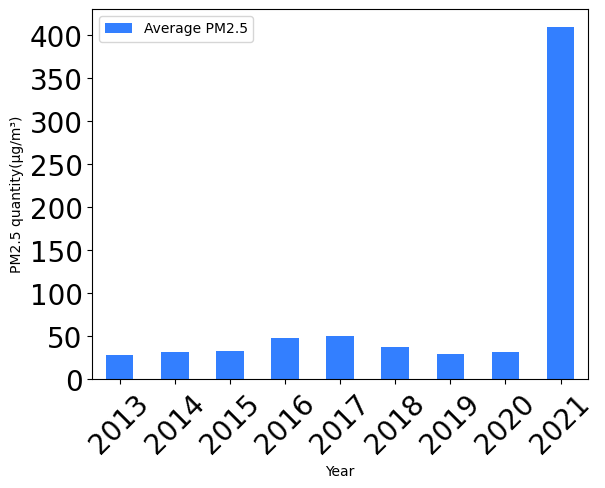

In [22]:
p1_df = pd.DataFrame({"Average PM2.5": daily_df.groupby("year")["PM2.5"].mean()}).reset_index()
p1_df
p1_df.plot("year", "Average PM2.5", kind='bar', color="#337fff", width=0.5);
plt.xlabel('Year')
plt.ylabel('PM2.5 quantity(µg/m³)')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.legend()
plt.xticks(rotation = 45)

In [23]:
daily_df

,datetime,month,year,station_id,PM2.5,PM10,NOx,O3,CO,HR,NO,NO2,TMP
13193,2013-01-01,1,2013,68,37.084448,79.583333,NaN,0.014000,0.418750,NaN,NaN,NaN,NaN
13194,2013-01-02,1,2013,68,16.040586,61.333333,NaN,0.011917,0.383750,NaN,NaN,NaN,NaN
13195,2013-01-03,1,2013,68,11.880552,57.739130,NaN,0.015958,0.364583,NaN,NaN,NaN,NaN
13196,2013-01-04,1,2013,68,13.000137,55.375000,NaN,0.013208,0.420833,NaN,NaN,NaN,NaN
13197,2013-01-05,1,2013,68,18.025929,72.625000,NaN,0.012542,0.431667,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
231587,2021-12-27,12,2021,426,28.956522,67.375000,0.036429,0.030750,1.684583,56.541667,NaN,0.024762,21.660833
231588,2021-12-28,12,2021,426,20.818182,55.833333,0.037508,0.026792,1.700000,44.375000,NaN,0.023225,23.731250
231589,2021-12-29,12,2021,426,16.857143,51.458333,0.045588,0.017083,1.732917,37.875000,NaN,0.026500,22.751250
231590,2021-12-30,12,2021,426,21.555556,51.750000,0.037229,0.029833,1.520000,42.916667,NaN,0.023929,22.988333


# hourly_df

In [24]:
hourly_df.head()

,datetime,station_id,PM2.5,PM10,NOx,O3,CO,HR,NO,NO2,...,HCT,HRI,IUV,PB,PP,PST,RS,TMPI,UVA,XIL
0,2015-04-02 09:00:00,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.361,NaN,NaN
1,2015-05-21 18:00:00,32,0.97112,NaN,NaN,NaN,NaN,24.416,NaN,NaN,...,NaN,NaN,NaN,569.61,0.00,NaN,41.1090,16.723,NaN,NaN
2,2015-05-21 19:00:00,32,0.97122,0.18008,0.111060,0.020706,NaN,31.282,0.005918,0.104480,...,NaN,NaN,NaN,570.01,1.55,NaN,8.0007,16.745,NaN,NaN
3,2015-05-21 19:00:00,32,0.97122,0.18008,0.111060,0.020706,NaN,31.282,0.104480,0.104480,...,NaN,NaN,NaN,570.01,1.55,NaN,8.0007,16.745,NaN,NaN
4,2015-05-21 20:00:00,32,0.93155,0.38415,0.058019,0.030228,NaN,36.145,0.003471,0.054585,...,NaN,NaN,NaN,569.97,0.00,NaN,7.3412,16.586,NaN,NaN


In [25]:
# for y in daily_df["year"].unique()[3:]:
#     value = (mean_y[y])
#     print(y)
#     (daily_df[daily_df["year"]==y]["PM2.5"].fillna(value, inplace = True))


In [26]:
daily_df[daily_df["year"] == 2010]["PM10"]

Series([], Name: PM10, dtype: float64)

# rsinaica_df

In [27]:
hourly_df.drop_duplicates(["datetime", "station_id"])
hourly_df.sort_values("datetime")

,datetime,station_id,PM2.5,PM10,NOx,O3,CO,HR,NO,NO2,...,HCT,HRI,IUV,PB,PP,PST,RS,TMPI,UVA,XIL
1838329,2000-01-01 00:00:00,109,NaN,NaN,NaN,NaN,NaN,NaN,0.039,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2771691,2000-01-01 00:00:00,128,NaN,NaN,NaN,NaN,NaN,NaN,0.010,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1474466,2000-01-01 00:00:00,102,NaN,NaN,NaN,NaN,NaN,NaN,0.019,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4652322,2000-01-01 00:00:00,256,NaN,NaN,NaN,NaN,NaN,NaN,0.027,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4832607,2000-01-01 00:00:00,260,NaN,NaN,NaN,NaN,NaN,NaN,0.061,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4652320,2021-12-31 23:00:00,256,33.00,59.000,0.06800,0.0020,1.60,48.0,NaN,0.05300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1838327,2021-12-31 23:00:00,109,NaN,47.873,NaN,0.0194,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.053,NaN,NaN
3540694,2021-12-31 23:00:00,143,NaN,154.000,0.10920,0.0040,2.73,60.0,NaN,0.05450,...,NaN,NaN,NaN,715.7,0.0,NaN,0.0,NaN,NaN,NaN
443186,2021-12-31 23:00:00,70,26.09,65.470,0.01515,0.0126,2.19,NaN,NaN,0.00808,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
rsinaica_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341 entries, 0 to 340
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   station_id         341 non-null    int64  
 1   station_name       341 non-null    object 
 2   station_code       341 non-null    object 
 3   network_id         341 non-null    int64  
 4   network_name       334 non-null    object 
 5   network_code       340 non-null    object 
 6   street             187 non-null    object 
 7   ext                154 non-null    object 
 8   interior           74 non-null     object 
 9   colonia            186 non-null    object 
 10  zip                143 non-null    object 
 11  state_code         299 non-null    float64
 12  municipio_code     299 non-null    float64
 13  year_started       138 non-null    float64
 14  altitude           320 non-null    float64
 15  address            138 non-null    object 
 16  date_validated     20 non-

make new dataframe caontain station_id and network_name(city)

In [29]:
data = {"station_id":rsinaica_df["station_id"],
        "network_name":rsinaica_df["network_name"]}
new_df = pd.DataFrame(data)

In [30]:
new_df.fillna("Unknown")

,station_id,network_name
0,397,Unknown
1,344,Unknown
2,365,Unknown
3,393,Unknown
4,394,Unknown
...,...,...
336,239,Zacatecas
337,295,Zacatecas
338,238,Zacatecas
339,135,Zacatepec


#  prepare data for คำนวณ อับดับเมือง
merge new_df and daily_df

In [31]:
daily_station = pd.merge(daily_df, new_df,on="station_id")

In [32]:
daily_station.sort_values(by=["year", "month"], inplace = True)

In [33]:
daily_station[daily_station["station_id"]==59]

,datetime,month,year,station_id,PM2.5,PM10,NOx,O3,CO,HR,NO,NO2,TMP,network_name
127635,2014-01-01,1,2014,59,15.333333,17.083333,NaN,0.015042,2.512500,NaN,0.008950,0.008950,NaN,Durango
127636,2014-01-02,1,2014,59,15.333333,34.166667,NaN,0.015333,2.554167,NaN,0.010067,0.010067,NaN,Durango
127637,2014-01-03,1,2014,59,15.333333,51.666667,NaN,0.021000,2.533333,NaN,0.011908,0.011908,NaN,Durango
127638,2014-01-04,1,2014,59,15.333333,87.958333,NaN,0.012083,2.791667,NaN,0.016837,0.016837,NaN,Durango
127639,2014-01-05,1,2014,59,15.333333,67.625000,NaN,0.012583,2.762500,NaN,0.013379,0.013379,NaN,Durango
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130150,2021-12-26,12,2021,59,28.886417,85.633917,0.021656,0.013516,2.152883,NaN,NaN,0.014519,16.265167,Durango
130151,2021-12-27,12,2021,59,21.398742,91.584542,0.020024,0.014789,2.054071,NaN,NaN,0.013496,16.534571,Durango
130152,2021-12-28,12,2021,59,23.124157,75.219429,0.035254,0.025515,2.968293,NaN,NaN,0.018598,12.744843,Durango
130153,2021-12-29,12,2021,59,9.607282,38.459392,0.016715,0.014223,1234.715545,NaN,NaN,0.013398,16.059636,Durango
